### Spark HW3 Moive Recommendation
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)
The deadline is 01/05/2019

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [7]:
movies.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [8]:
ratings.show(5)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [9]:
links.show(5)

+-------+-------+------+
movieId| imdbId|tmdbId|
+-------+-------+------+
 1|0114709| 862|
 2|0113497| 8844|
 3|0113228| 15602|
 4|0114885| 31357|
 5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows

In [10]:
tags.show(5)

+------+-------+---------------+----------+
userId|movieId| tag| timestamp|
+------+-------+---------------+----------+
 2| 60756| funny|1445714994|
 2| 60756|Highly quotable|1445714996|
 2| 60756| will ferrell|1445714992|
 2| 89774| Boxing story|1445715207|
 2| 89774| MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows

In [11]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [12]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

## Part 1: Spark SQL and OLAP

### Q1: The number of Users

In [15]:
num_user = ratings.select('userID').distinct().count()
print('The number of Users is {}'.format(num_user))

The number of Users is 610

### Q2: The number of Movies

In [17]:
num_movie = movies.select('movieID').distinct().count()
print ('The number of movies is {}'.format(num_movie))

The number of movies is 9742

### Q3:  How many movies are rated by users? List movies not rated before

In [19]:
movies_rated = ratings.select('movieID').distinct().count()
print ('{} movies are rated by users'.format(movies_rated))

9724 movies are rated by users

In [20]:
spark.sql("select distinct movies.movieID from movies left join ratings on movies.movieID = ratings.movieID where ratings.movieID is null").show()

+-------+
movieID|
+-------+
 5721|
 26085|
 1076|
 3338|
 8765|
 6668|
 7020|
 32160|
 3456|
 4194|
 30892|
 2939|
 7792|
 34482|
 32371|
 6849|
 25855|
 85565|
+-------+

### Q4: List Movie Genres

In [22]:
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")

In [23]:
spark.sql("select distinct genres from movies").show()

+--------------------+
 genres|
+--------------------+
Comedy|Horror|Thr...|
Adventure|Sci-Fi|...|
Action|Adventure|...|
 Action|Drama|Horror|
Action|Animation|...|
Animation|Childre...|
Action|Adventure|...|
 Adventure|Sci-Fi|
Documentary|Music...|
Adventure|Childre...|
 Adventure|Animation|
 Musical|Romance|War|
Action|Adventure|...|
Adventure|Childre...|
Comedy|Crime|Horr...|
Crime|Drama|Fanta...|
Comedy|Mystery|Th...|
 Adventure|Fantasy|
Horror|Romance|Sc...|
Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows

### Q5: Movie for Each Category

In [25]:
movie_category = spark.sql("select genres, count(*) as count from movies group by genres order by count desc")
movie_category.show()

+--------------------+-----+
 genres|count|
+--------------------+-----+
 Drama| 1053|
 Comedy| 946|
 Comedy|Drama| 435|
 Comedy|Romance| 363|
 Drama|Romance| 349|
 Documentary| 339|
Comedy|Drama|Romance| 276|
 Drama|Thriller| 168|
 Horror| 167|
 Horror|Thriller| 135|
 Crime|Drama| 134|
Crime|Drama|Thriller| 125|
 Drama|War| 114|
 Comedy|Crime| 101|
 Action|Comedy| 92|
 Thriller| 84|
 Children|Comedy| 74|
 Comedy|Horror| 69|
Action|Adventure|...| 66|
Action|Crime|Thri...| 66|
+--------------------+-----+
only showing top 20 rows

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [27]:
from pyspark.mllib.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row

In [28]:
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [29]:
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

In [30]:
# check three rows
rating_data.take(3)

Out[ 8 ]: [('1', '1', '4.0'), ('1', '3', '4.0'), ('1', '6', '4.0')]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [32]:
train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)

In [33]:
train.cache()

Out[ 10 ]: PythonRDD[33] at RDD at PythonRDD.scala:55

In [34]:
validation.cache()

Out[ 11 ]: PythonRDD[34] at RDD at PythonRDD.scala:55

In [35]:
test.cache()

Out[ 12 ]: PythonRDD[35] at RDD at PythonRDD.scala:55

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [37]:
def train_ALS(train_data, validation_data, num_iters, reg_params, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_params:
            # train ALS model
            model = ALS.train(train_data, rank, num_iterations,lambda_=reg)
            # make prediction
            testdata = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            rates_and_preds = validation_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
            # get the RMSE
            error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [38]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9700403539788321
6 latent factors and regularization = 0.1: validation RMSE is 0.9102066326731292
6 latent factors and regularization = 0.2: validation RMSE is 0.8965228043811307
6 latent factors and regularization = 0.4: validation RMSE is 0.9672108927490705
6 latent factors and regularization = 0.8: validation RMSE is 1.1894043483118304
8 latent factors and regularization = 0.05: validation RMSE is 0.9908274894289824
8 latent factors and regularization = 0.1: validation RMSE is 0.9183368703857794
8 latent factors and regularization = 0.2: validation RMSE is 0.896460701244618
8 latent factors and regularization = 0.4: validation RMSE is 0.9668949541572379
8 latent factors and regularization = 0.8: validation RMSE is 1.1894082951614975
10 latent factors and regularization = 0.05: validation RMSE is 0.9957369826787302
10 latent factors and regularization = 0.1: validation RMSE is 0.9154025436769997
10 latent factors and regularization = 0.2: validation RMSE is 0.8973234954924127
10 latent factors and regularization = 0.4: validation RMSE is 0.9671133484499448
10 latent factors and regularization = 0.8: validation RMSE is 1.1894068518111083
12 latent factors and regularization = 0.05: validation RMSE is 1.0071995915616097
12 latent factors and regularization = 0.1: validation RMSE is 0.9178954529938843
12 latent factors and regularization = 0.2: validation RMSE is 0.897567075138096
12 latent factors and regularization = 0.4: validation RMSE is 0.9666790209253405
12 latent factors and regularization = 0.8: validation RMSE is 1.1894071642921047
14 latent factors and regularization = 0.05: validation RMSE is 1.008732219397395
14 latent factors and regularization = 0.1: validation RMSE is 0.917361226381853
14 latent factors and regularization = 0.2: validation RMSE is 0.8974137615805376
14 latent factors and regularization = 0.4: validation RMSE is 0.9670234457390782
14 latent factors and regularization = 0.8: validation RMSE is 1.1894066676271817

The best model has 8 latent factors and regularization = 0.2
Total Runtime: 192.77 seconds

In [39]:
def train_ALS_modified(train_data, validation_data, num_iters, reg_param, rank):
    min_error = float('inf')
    best_model = None
    for iter in num_iters:
            # train ALS model
            model = ALS.train(train_data, rank, iter,lambda_=reg_param)
            # make prediction
            testdata = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            rates_and_preds = validation_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
            # get the RMSE
            error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
            print ('{} latent factors and regularization = {} with {} iterations: validation RMSE is {}'.format(rank, reg_param,iter, error))
            if error < min_error:
                min_error = error
                best_model = model
    print ('\nThe best model with {} latent factors and {} regularization is iter = {}'.format(rank, reg_param,iter))
    return best_model

In [40]:
iter_array = [1, 2, 5, 10]
import time
start_time = time.time()
train_ALS_modified(train, validation, iter_array, 0.2,10)
print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

10 latent factors and regularization = 0.2 with 1 iterations: validation RMSE is 2.8682156731254196
10 latent factors and regularization = 0.2 with 2 iterations: validation RMSE is 1.048855278454772
10 latent factors and regularization = 0.2 with 5 iterations: validation RMSE is 0.8967807250635779
10 latent factors and regularization = 0.2 with 10 iterations: validation RMSE is 0.8963743300731765

The best model with 10 latent factors and 0.2 regularization is iter = 10
Total Runtime: 13.49 seconds

In [41]:
def train_ALS_RMSE(train_data, validation_data, num_iters, reg_param, rank):
  errors = []
  for i in num_iters:
    # train ALS model
    model = ALS.train(train_data, rank, i,lambda_=reg_param)
    # make prediction
    testdata = validation_data.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    # get the rating result
    rates_and_preds = validation_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    # get the RMSE
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors.append(error)
  return errors
  

In [42]:
train_ALS_RMSE(train, validation, iter_array, 0.2,10)

Out[ 18 ]: [3.349374469649712, 1.0202449571386918, 0.9025476472433918, 0.8952214708992654]

In [43]:
# write your function to plot the learning curve
def plot_learning_curve(train,validation,iter_array,reg,rank):
    errors = train_ALS_RMSE(train, validation, iter_array, reg, rank)
    plt.plot(iter_array, errors, label='Training', linewidth=5)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('iterations', fontsize=20)
    plt.ylabel('RMSE', fontsize=20)
    display(plt.show())

In [44]:
plt.gcf().clear()

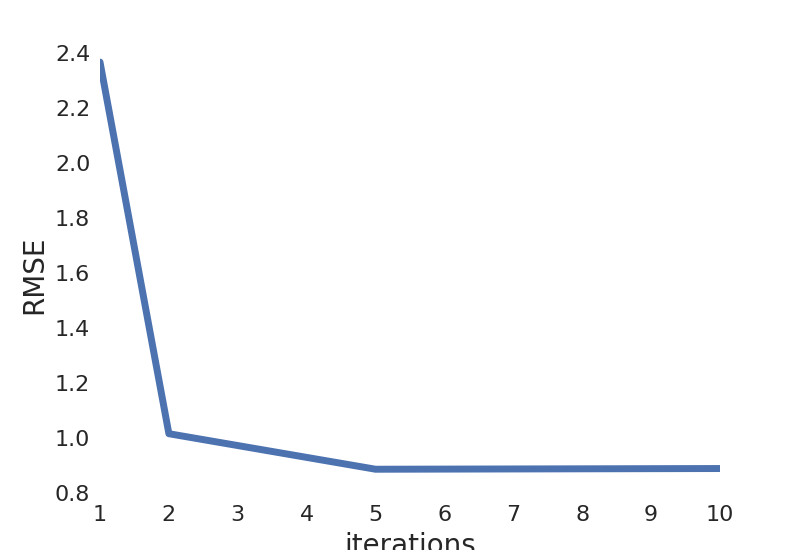

In [45]:
iter_array = [1, 2, 5, 10]
plot_learning_curve(train, validation,iter_array, 0.2, 12)

### Model testing
And finally, make a prediction and check the testing error.

In [47]:
model = ALS.train(train, 12,10,0.2)
test_for_predict_RDD = test.map(lambda x: (x[0], x[1]))
predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print ('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.8884987518673958

In [48]:
rate_and_pred = rates_and_preds.toDF()
rate_and_pred.show()

+-------------+--------------------+
 _1| _2|
+-------------+--------------------+
 [381, 34319]|[4.0, 3.088525777...|
 [414, 6062]|[3.0, 3.030815760...|
 [181, 437]|[2.0, 2.356334571...|
 [391, 4273]|[5.0, 2.722358134...|
 [117, 733]|[3.0, 3.302643299...|
 [600, 1348]|[2.5, 2.950664927...|
 [302, 780]|[4.0, 3.080502899...|
 [599, 437]|[1.5, 1.741585518...|
 [230, 6502]|[4.0, 2.810514489...|
 [307, 2361]|[2.0, 2.557492867...|
 [294, 3130]|[2.0, 1.934722346...|
 [555, 3763]|[3.0, 3.158436181...|
[272, 122922]|[2.0, 3.472207514...|
 [260, 8874]|[2.5, 3.738971449...|
 [528, 2470]|[2.0, 2.705210665...|
 [517, 1367]|[5.0, 2.047343224...|
 [489, 2193]|[3.5, 3.108596977...|
 [357, 1189]|[3.5, 4.037281638...|
 [307, 5309]|[1.5, 2.187551740...|
 [198, 1876]|[2.0, 2.733912800...|
+-------------+--------------------+
only showing top 20 rows